# 演習・交通手段分類（データの特徴をつかむ）

このNotebookでは、GPSデータの基本的な特徴をいくつか抽出します。

In [1]:
from geopy import distance
import numpy as np
from math import radians, cos, sin, asin, sqrt, atan2
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
# load the GPS data which we cleaned in 00_clean_GPS_data.ipynb
user = '010'
traj_df = pd.read_csv(f'./traj_{user}_labeled.csv', index_col=0)
# traj_df = pd.read_csv(f'./traj_{user}_labeled.csv', index_col=0)
traj_df.head(2)

/var/folders/x2/7ss5kcb12n1gtlpc8p2mtjtw0000gn/T/ipykernel_10032/953823710.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  traj_df = pd.read_csv(f'./traj_{user}_labeled.csv', index_col=0)


,latitude,longitude,height,days_total,date,time,record_dt,user,trans_trip,trans_mode
0,39.138159,117.217108,-36,39805.961748,2008-12-23,23:04:55,2008-12-23 23:04:55,10,NaN,NaN
1,39.138196,117.217068,-72,39805.961759,2008-12-23,23:04:56,2008-12-23 23:04:56,10,NaN,NaN


In [3]:
# exclude the rows containing no information about transportation mode
traj_df = traj_df.dropna(subset=['trans_mode'], axis=0)
print("Size of observations: {:,}".format(traj_df.shape[0]))
traj_df.head()

Size of observations: 534,140


,latitude,longitude,height,days_total,date,time,record_dt,user,trans_trip,trans_mode
0,39.845966,116.473938,131,39713.992662,2008-09-22,23:49:26,2008-09-22 23:49:26,10,163.0,train
1,39.846383,116.473363,135,39713.992674,2008-09-22,23:49:27,2008-09-22 23:49:27,10,163.0,train
2,39.846803,116.472788,141,39713.992685,2008-09-22,23:49:28,2008-09-22 23:49:28,10,163.0,train
3,39.847218,116.472213,141,39713.992697,2008-09-22,23:49:29,2008-09-22 23:49:29,10,163.0,train
4,39.847631,116.471641,141,39713.992708,2008-09-22,23:49:30,2008-09-22 23:49:30,10,163.0,train


## 一つ前の場所（ポイント）からの時間差を計算する
<!-- ## calculate time differences from previous points per trip -->

In [4]:
# convert time values to timestamp
traj_df['timestamp'] = traj_df['time'].apply(lambda x: pd.to_datetime(x))
# sort values by trip id (trans_trip) and timestamp
traj_df.sort_values(['trans_trip','timestamp'], inplace=True)
# create the start and end time for each trajectory
traj_df['time_delta'] = (traj_df.timestamp - traj_df.groupby(['trans_trip']).timestamp.shift(1))
traj_df['dt_seconds'] = traj_df['time_delta'].dt.seconds

Let's check the histogram of longest time between two points per trip.

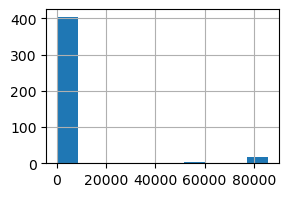

0.0       1.0
0.1       2.0
0.2       2.0
0.3       4.0
0.4      48.0
0.5      61.0
0.6      82.0
0.7     120.0
0.8     317.0
0.9    1076.0
Name: dt_seconds, dtype: float64


In [5]:
# plot the histogram of the maximum time differences between points per trip
trip_dt = traj_df.groupby(['trans_trip']).dt_seconds.max()
trip_dt.hist(bins=10, figsize=(3,2))
plt.show()
# Let's also print out the percentiles of the maximum time differences between points per trip
print(trip_dt.quantile(np.arange(0, 1, 0.1)))

In [6]:
# summary info on time differences between points, grouped by trip id (trans_trip)
(traj_df.groupby(['trans_mode','trans_trip'])
        .time_delta
        .max()
        .dt.seconds
        .groupby(level=0).agg(['mean','median','max','min','count']))

,mean,median,max,min,count
trans_mode,,,,,
airplane,3699.000000,3699.0,7394.0,4.0,2
bus,2597.941176,67.5,85896.0,2.0,34
car,119.000000,119.0,119.0,119.0,1
subway,1916.595745,59.0,85903.0,2.0,47
taxi,7997.218750,68.5,85474.0,2.0,96
train,8911.393939,1061.0,84677.0,2.0,99
walk,602.006579,3.0,85263.0,1.0,152


Since airplane and car trips are less, we remove these modes for further analysis.

In [7]:
traj_df = traj_df[~traj_df['trans_mode'].isin(['airplane','car'])]

## 前のポイントからの距離
<!-- distances from previous points -->

In [8]:
# store previous points' latitude and logitude by using `shift` function of pandas
traj_df[['latitude_prev','longitude_prev']] = traj_df.groupby('trans_trip')[['latitude','longitude']].shift(1)

In [9]:
def calc_distance(lat2, lon2, lat1, lon1):
    """function to calculate distances between two coordinates
    """
    if pd.isna(lat1) or pd.isna(lon1):
        return np.nan
    else:
        return distance.great_circle((lat2, lon2), (lat1, lon1)).km

In [10]:
# map the calculation function above to the dataframe
traj_df['distance'] = traj_df.apply(lambda x:calc_distance(x["latitude"], x["longitude"], x['latitude_prev'], x['longitude_prev']), axis=1)

In [11]:
traj_df.head(2)

,latitude,longitude,height,days_total,date,time,record_dt,user,trans_trip,trans_mode,timestamp,time_delta,dt_seconds,latitude_prev,longitude_prev,distance
1,39.894178,116.318200,-777,39535.621296,2008-03-28,14:54:40,2008-03-28 14:54:40,10,1.0,train,2023-06-07 14:54:40,NaT,NaN,NaN,NaN,NaN
2,39.894505,116.321132,-777,39535.621690,2008-03-28,14:55:14,2008-03-28 14:55:14,10,1.0,train,2023-06-07 14:55:14,0 days 00:00:34,34.0,39.894178,116.3182,0.252764


## 速度
<!-- speed -->
次に速度：距離(km)/時を計算します

In [13]:
traj_df['speed'] = \
            np.where(((traj_df['distance'].notnull())&(traj_df['dt_seconds']!=0)), traj_df['distance'] / 
                     (traj_df['dt_seconds'] / 3600), 0)

In [14]:
# Let's check the descriptions of speed per transportation mode
traj_df.groupby(['trans_mode']).speed.agg(['mean','min','max','std'])

,mean,min,max,std
trans_mode,,,,
bus,40.731893,0.0,219.970336,29.834764
subway,52.369217,0.0,217.578404,25.219674
taxi,30.355116,0.0,156.129306,27.505678
train,87.305798,0.0,76412.488301,129.458882
walk,5.453786,0.0,77.700333,3.290184


## 加速度
<!-- Accelation -->

2点間の速度の差/2点間の時間の差でAccelation（加速度）を計算します。

In [15]:
# store previous points' speed
traj_df['speed_prev'] = traj_df.groupby('trans_trip')['speed'].shift(1)

In [16]:
def calc_accel(speed_1, speed_2, time_diff_sec):
    """function to calculate acceleration between two points
    """
    speed_delta = speed_2 - speed_1
    if (time_diff_sec == 0) or (speed_delta == 0):
        return 0
    return speed_delta / time_diff_sec

In [17]:
# map the above calculation fuction to the dataframe
traj_df['accel'] = traj_df.apply(lambda x: calc_accel(x['speed'], x['speed_prev'], x['dt_seconds']), axis=1)

In [18]:
# check basic statistics of acceleration per transportation mode
traj_df.groupby('trans_mode')['accel'].describe()

,count,mean,std,min,25%,50%,75%,max
trans_mode,,,,,,,,
bus,35156.0,-0.072119,5.457844,-166.371582,-1.161253,-3.753887e-06,1.108991,178.138813
subway,20338.0,-0.091452,6.851066,-136.151441,-1.233928,2.384665e-01,1.791577,126.904634
taxi,56731.0,-0.061755,4.192712,-97.929174,-1.272490,0.000000e+00,1.300822,96.055705
train,380835.0,-0.007112,4.349676,-1122.655229,-0.973044,4.474713e-09,0.987760,1293.744609
walk,36954.0,-0.051443,3.310213,-64.769768,-1.191070,2.163060e-03,1.201445,59.242515


## Angular velocity
<!-- 角速度 -->

ここでは、2点間の角度の差／2点間の時間の差でAngular velocityを計算します。

そのためにまず、2点間の角度の差を計算します。

In [19]:
def calc_angle(lat1, lat2, lon1, lon2):
    """function to calculate angle differences between two coordinates
    """
    x = cos(lat2) * sin(lon2-lon1)
    y = cos(lat1) * sin(lat2) - sin(lat1) * cos(lat2) * cos(lon2-lon1)
    brng = atan2(x, y)
    brng = np.degrees(brng)
    brng = brng + 360 if brng < 0 else brng
    return brng

In [20]:
# apply the calculation function abvoe to the dataframe
traj_df['angle'] = traj_df.apply(lambda x: calc_angle(x['latitude'], x['latitude_prev'], x['longitude'], x['longitude_prev']), axis=1)

In [21]:
# print out the description of angle differences between two points per transportation mode
traj_df.groupby(['trans_mode'])['angle'].describe()

,count,mean,std,min,25%,50%,75%,max
trans_mode,,,,,,,,
bus,35156.0,159.299021,111.391769,-0.0,68.399355,172.127466,255.799236,359.999455
subway,20338.0,137.644859,104.230577,0.0,19.438924,173.706695,196.554703,359.827198
taxi,56731.0,158.724686,116.988570,-0.0,29.485250,178.534543,226.851081,359.929870
train,380835.0,179.733586,103.023225,0.0,98.886739,179.800484,269.325408,359.999506
walk,36954.0,181.486218,104.497955,0.0,97.345459,181.463673,269.999640,359.812308


Angular velocityを求めます。

In [22]:
def calc_angular_velocity(angle1, angle2, time_diff_sec):
    """function to calculate angular velocity
    """
    bear_delta = angle2 - angle1
    if time_diff_sec == 0:
        return 0
    return abs(bear_delta / time_diff_sec)

In [23]:
# create a new column holding the previous points' angle difference
traj_df['angle_prev'] = traj_df.groupby('trans_trip')['angle'].shift(1)
# apply the calculation function to the dataframe
traj_df['angular_velocity'] = traj_df.apply(lambda x: calc_angular_velocity(x['angle'],x['angle_prev'],x['dt_seconds']), axis=1)
traj_df['angular_velocity'].describe()

count    529586.000000
mean         10.510742
std          45.292572
min           0.000000
25%           0.272122
50%           0.870065
75%           2.537062
max         359.997255
Name: angular_velocity, dtype: float64

## 特徴の可視化

上で作ったいくつかの特徴を可視化してそれぞれがどのように交通手段と関連があるか確認します。

In [24]:
# define a color list for visualizations
colors = ['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']

<!-- #### Relation between angular velocity and speed per trip -->
#### トリップごとのAngular velocity とスピードの関係性

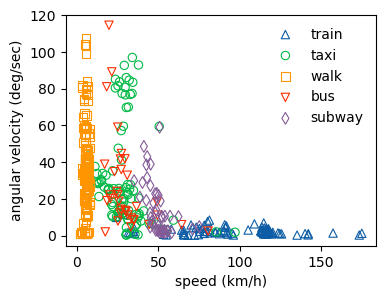

In [25]:
fig, ax = plt.subplots(figsize=(4, 3))
markers = ['^', 'o', 's', 'v', 'd']
# iterate over transportation modes
for i, mode in enumerate(traj_df['trans_mode'].unique()):
    # create sub-dataframe holding the rows with the mode
    chunk = traj_df[traj_df['trans_mode']==mode]
    # create mean scores of speed and angular_velocity per trip
    trip_df = chunk.groupby('trans_trip')[['speed', 'angular_velocity']].mean()
    # create scatter plots of speed and angular_velocity per trip
    ax.scatter(trip_df['speed'], trip_df['angular_velocity'], facecolor = 'None', 
               marker = markers[i], edgecolor=colors[i], label=mode, linewidth=0.8)
ax.legend(frameon=False)
ax.set_xlabel('speed (km/h)')
ax.set_ylabel('angular velocity (deg/sec)')
plt.show()

<!-- #### Plot box plots of acceleration scores per trip per transportation mode -->
### 各交通手段ごとの加速度の箱ひげ図の確認

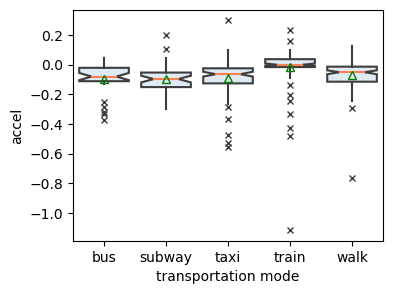

In [26]:
fig, ax = plt.subplots(figsize=(4, 3))
markers = ['^', 'o', 's', 'v', 'd']
accel_df = traj_df.groupby(['trans_mode', 'trans_trip'])[['accel']].mean().reset_index()
sns.boxplot(data=accel_df, x="trans_mode", y="accel", 
            # showfliers=True, 
            notch=True, showcaps=False,
            showmeans=True,
            meanprops={'markerfacecolor':'none','markeredgecolor':'green'},
            flierprops={"marker": "x"},
            boxprops={"facecolor": (.4, .6, .8, .2)},
            medianprops={"color": "coral"}, 
            ax = ax)
ax.set_xlabel('transportation mode')
plt.show()

## 次の分析のために作成した特徴量データを保存します。

In [27]:
# drop the rows without dt_seconds values
traj_df = traj_df[traj_df['dt_seconds'].notnull()]
# drop the rows which has 0 seconds gaps from previous points
traj_df = traj_df[~(traj_df['dt_seconds']==0)]

In [29]:
# PLEASE REPLACE THE BELOW PATH WITH YOUR PATH
path = f'traj_{user}_labeled_with_features.csv'
traj_df.to_csv(path)